# Facebook Marketplace Recommendation Ranking System - CNN Modelling

## Library Imports & Import Data

In [30]:
import numpy as np
import pandas as pd
from zipfile import ZipFile
import random
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set()
from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
'''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
# When running on the CuDNN backend, two further options must be set
torch.backends.cudnn.deterministic = True
# Set a fixed value for the hash seed
# os.environ['PYTHONHASHSEED'] = str(SEED)

In [3]:
products_df = pd.read_csv('Products.csv', lineterminator='\n')
def clean_tabular_data(df):
    return (df.drop(columns='Unnamed: 0')
                .assign(price = df.price.str.replace(',',''))
                .assign(price = lambda df_: df_.price.str.extract(r'£([\d]+.[\d]+)').astype('float'),
                        category_0 = df.category.str.split(' / ', expand=True)[0],
                        category_1 = df.category.str.split(' / ', expand=True)[1])
                .drop(columns='category')
    )
cleaned_df = clean_tabular_data(products_df)
cleaned_df

,id,product_name,product_description,price,location,category_0,category_1
0,243809c0-9cfc-4486-ad12-3b7a16605ba9,"Mirror wall art | in Wokingham, Berkshire | Gu...","Mirror wall art. Posted by Nisha in Dining, Li...",5.0,"Wokingham, Berkshire",Home & Garden,"Dining, Living Room Furniture"
1,1c58d3f9-8b93-47ea-9415-204fcc2a22e6,"Stainless Steel Food Steamer | in Inverness, H...",Morphy Richard’s (model no 48755)Stainless ste...,20.0,"Inverness, Highland",Home & Garden,Other Household Goods
2,860673f1-57f6-47ba-8d2f-13f9e05b8f9a,"Sun loungers | in Skegness, Lincolnshire | Gum...",I have 2 of these - collection only as I don’t...,20.0,"Skegness, Lincolnshire",Home & Garden,Garden & Patio
3,59948726-29be-4b35-ade5-bb2fd7331856,Coffee side table from Ammunition ammo box hai...,Great reclaimed army ammunition box used as co...,115.0,"Radstock, Somerset",Home & Garden,"Dining, Living Room Furniture"
4,16dbc860-696e-4cda-93f6-4dd4926573fb,Modern Shannon Sofa for sale at low cost | in ...,New Design Shannon Corner sofa 5 Seater Avail...,450.0,"Delph, Manchester",Home & Garden,"Dining, Living Room Furniture"
...,...,...,...,...,...,...,...
7151,c4148656-78a9-4f3e-b393-134fdc5ef900,Sony PlayStation VR Move Bundle | in Acocks Gr...,Sony PlayStation VR Move Bundle353CASH ON COLL...,260.0,"Acocks Green, West Midlands",Video Games & Consoles,Consoles
7152,564e3411-768d-4250-a624-b119d696f103,"Playstation VR V2 Bundle | in Acocks Green, We...",Playstation VR V2 Bundle355CASH ON COLLECTION ...,235.0,"Acocks Green, West Midlands",Video Games & Consoles,Consoles
7153,2b0a652b-46a2-4297-b619-5efeeb222787,"Oculus quest 2 256gb | in Montrose, Angus | Gu...",Pick up only £250Comes with two pistols stocks...,250.0,"Montrose, Angus",Video Games & Consoles,Other Video Games & Consoles
7154,719fd40a-870e-4144-b324-55dff2e66fb4,Logitech driving force shifter | in Carrickfer...,Bought at christmas from currys retailing at £...,30.0,"Carrickfergus, County Antrim",Video Games & Consoles,Video Game Accessories


In [4]:
images_df = pd.read_csv('Images.csv', lineterminator="\n").drop(columns='Unnamed: 0')
images_df

,id,product_id
0,912bb259-3ad9-457b-9db1-ce1da9016057,5f5f57d7-778f-4336-bb10-b43863418c8c
1,b166d305-b852-4bdd-83f4-465b20da94fa,5f5f57d7-778f-4336-bb10-b43863418c8c
2,68f5a29d-0075-4d60-81c1-ab684a82e50c,c2c8949f-3cde-4651-a234-4a4a1b2a9ad4
3,f6a309d7-d247-446a-9b5e-aceefdd4334d,c2c8949f-3cde-4651-a234-4a4a1b2a9ad4
4,2c2b3a6f-15b3-4289-937a-15482d9f5781,8292aa4e-7f1b-4655-bf0e-f1f2c9e3ffaf
...,...,...
12599,cdec1c5c-c4b1-42db-afbe-3fa68ea4b87d,2b0a652b-46a2-4297-b619-5efeeb222787
12600,dc99e40f-6b15-494d-9fb7-f0d02e9781f9,719fd40a-870e-4144-b324-55dff2e66fb4
12601,c8488028-bf07-4258-a4c2-56d2fe387835,719fd40a-870e-4144-b324-55dff2e66fb4
12602,c6113145-89c8-47cd-9211-38f29d016cc7,86d1806b-5575-4a7e-9160-f24f12be6c95


In [5]:
merged_df = (pd.merge(images_df, cleaned_df, left_on='product_id', right_on='id', how='inner', validate='many_to_one', suffixes=('', '_y'))
                .drop(columns='id_y')
                .rename(columns= lambda col: 'image_id' if col == 'id' else col))
merged_df

,image_id,product_id,product_name,product_description,price,location,category_0,category_1
0,912bb259-3ad9-457b-9db1-ce1da9016057,5f5f57d7-778f-4336-bb10-b43863418c8c,"King Size Pine Bedframe | in Hove, East Sussex...","Pine king sized Bedframe, originally from Ikea...",100.0,"Hove, East Sussex",Home & Garden,Beds & Bedroom Furniture
1,b166d305-b852-4bdd-83f4-465b20da94fa,5f5f57d7-778f-4336-bb10-b43863418c8c,"King Size Pine Bedframe | in Hove, East Sussex...","Pine king sized Bedframe, originally from Ikea...",100.0,"Hove, East Sussex",Home & Garden,Beds & Bedroom Furniture
2,68f5a29d-0075-4d60-81c1-ab684a82e50c,c2c8949f-3cde-4651-a234-4a4a1b2a9ad4,Decorative black iron water pump and sump pump...,Working water pump and sump pump. Has been use...,100.0,"Loughborough, Leicestershire",Home & Garden,Garden & Patio
3,f6a309d7-d247-446a-9b5e-aceefdd4334d,c2c8949f-3cde-4651-a234-4a4a1b2a9ad4,Decorative black iron water pump and sump pump...,Working water pump and sump pump. Has been use...,100.0,"Loughborough, Leicestershire",Home & Garden,Garden & Patio
4,2c2b3a6f-15b3-4289-937a-15482d9f5781,8292aa4e-7f1b-4655-bf0e-f1f2c9e3ffaf,"Marquee & Gazebo Hire | in Downpatrick, County...",Ranges of sizes available Long and short term ...,10.0,"Downpatrick, County Down",Home & Garden,Garden & Patio
...,...,...,...,...,...,...,...,...
12599,cdec1c5c-c4b1-42db-afbe-3fa68ea4b87d,2b0a652b-46a2-4297-b619-5efeeb222787,"Oculus quest 2 256gb | in Montrose, Angus | Gu...",Pick up only £250Comes with two pistols stocks...,250.0,"Montrose, Angus",Video Games & Consoles,Other Video Games & Consoles
12600,dc99e40f-6b15-494d-9fb7-f0d02e9781f9,719fd40a-870e-4144-b324-55dff2e66fb4,Logitech driving force shifter | in Carrickfer...,Bought at christmas from currys retailing at £...,30.0,"Carrickfergus, County Antrim",Video Games & Consoles,Video Game Accessories
12601,c8488028-bf07-4258-a4c2-56d2fe387835,719fd40a-870e-4144-b324-55dff2e66fb4,Logitech driving force shifter | in Carrickfer...,Bought at christmas from currys retailing at £...,30.0,"Carrickfergus, County Antrim",Video Games & Consoles,Video Game Accessories
12602,c6113145-89c8-47cd-9211-38f29d016cc7,86d1806b-5575-4a7e-9160-f24f12be6c95,"20 GAMES & NINTENDO SWITCH BUNDLE | in Poole, ...",Nintendo Switch console only used 2/3 times. A...,450.0,"Poole, Dorset",Video Games & Consoles,Games


<class 'numpy.ndarray'>


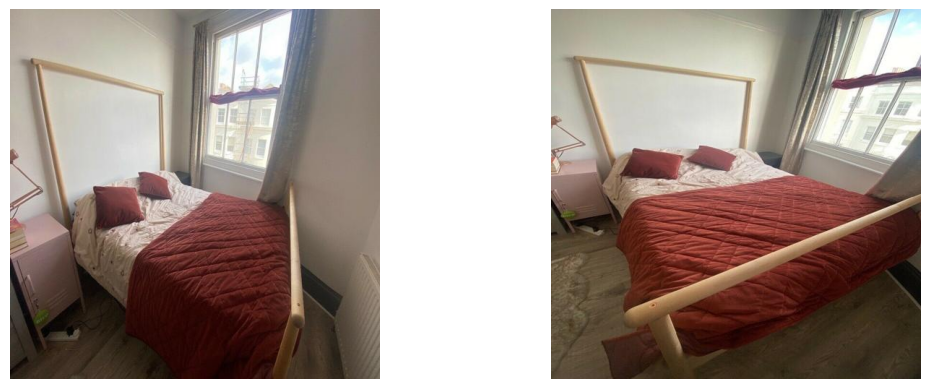

In [85]:
fig, ax = plt.subplots(1,2, figsize=(12.8, 4.8))
img = mpimg.imread(f'./cleaned_images/{merged_df.image_id[0]}.jpg')
ax[0].imshow(img)
ax[0].axis('off')
img = mpimg.imread(f'./cleaned_images/{merged_df.image_id[1]}.jpg')
ax[1].imshow(img)
ax[1].axis('off');
print(type(img))

In [86]:
img = Image.open(f'./cleaned_images/{merged_df.image_id[0]}.jpg')
print(type(img))
# fig, ax = plt.subplots(1,2, figsize = (12.8, 4.8))
# ax[0].imshow(img)
# ax[0].grid('on')

<class 'PIL.JpegImagePlugin.JpegImageFile'>


## Create Dataset

In [43]:
labels = sorted(cleaned_df.category_0.unique())
encoder = dict(zip(labels, range(len(labels))))
decoder = dict(zip(range(len(labels)), labels))
encoder

{'Appliances': 0,
 'Baby & Kids Stuff': 1,
 'Clothes, Footwear & Accessories': 2,
 'Computers & Software': 3,
 'DIY Tools & Materials': 4,
 'Health & Beauty': 5,
 'Home & Garden': 6,
 'Music, Films, Books & Games': 7,
 'Office Furniture & Equipment': 8,
 'Other Goods': 9,
 'Phones, Mobile Phones & Telecoms': 10,
 'Sports, Leisure & Travel': 11,
 'Video Games & Consoles': 12}

In [87]:
# All images are RBG and resized to 512x512

class Dataset(torch.utils.data.Dataset):
    def __init__(self, img_details, img_dir, encoder):
        self.img_id = img_details.image_id
        self.img_labels = img_details.category_0
        self.img_labels_encoded = self.img_labels.replace(encoder)
        self.img_dir = img_dir
    
    def __len__(self):
        return len(self.img_id)
    
    def __getitem__(self, idx):
        img_path = img_path = self.img_dir + self.img_id.iloc[idx] + '.jpg'
        transform = ToTensor()
        image = transform(Image.open(img_path))
        label = torch.tensor(self.img_labels_encoded.iloc[idx]).type(torch.uint8)
        return image, label

data = Dataset(merged_df, './cleaned_images/', encoder)
dataloader = torch.utils.data.DataLoader(data, batch_size=64, shuffle=False)

In [88]:
image, label = next(iter(dataloader))
print(f'Feature batch shape: {image.size()}')
print(f'Feature batch type: {image.type()}')
print(f'Labels batch shape: {label.size()}')
print(f'Labels batch type: {label.type()}')

Feature batch shape: torch.Size([64, 3, 512, 512])
Feature batch type: torch.FloatTensor
Labels batch shape: torch.Size([64])
Labels batch type: torch.ByteTensor


In [62]:
# create a stratified train, validation and test idx set
# 70/15/15 split
training_idx, test_idx = train_test_split(np.arange(merged_df.shape[0]), test_size=0.15, shuffle=True, stratify=merged_df.category_0)
train_idx, valid_idx = train_test_split(training_idx, test_size=0.15/0.85, shuffle=True, stratify=merged_df.loc[training_idx].category_0)
len(train_idx), len(valid_idx), len(test_idx)

(8822, 1891, 1891)

In [89]:
batch_size = 64
train_dataset = Dataset(merged_df.loc[train_idx], './cleaned_images/', encoder)
val_dataset = Dataset(merged_df.loc[valid_idx], './cleaned_images/', encoder)
test_dataset = Dataset(merged_df.loc[test_idx], './cleaned_images/', encoder)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for (idx, (X, y)) in enumerate(train_dataloader):
    if idx < 3:
        print(X.shape, y.shape)
    else:
        break

torch.Size([64, 3, 512, 512]) torch.Size([64])
torch.Size([64, 3, 512, 512]) torch.Size([64])
torch.Size([64, 3, 512, 512]) torch.Size([64])


## Define the CNN

In [92]:
class CNNModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = torch.nn.Sequential(
                torch.nn.Conv2d(3, 8, 7),
                torch.nn.ReLU(),
                torch.nn.Conv2d(8, 16, 7),
                torch.nn.ReLU(),
                torch.nn.Conv2d(16, 16, 7),
                # torch.nn.ReLU(),
                # torch.nn.Conv2d(16, 16, 7),
                # torch.nn.ReLU(),
                # torch.nn.Conv2d(16, 16, 7),
                # torch.nn.ReLU(),
                # torch.nn.Conv2d(16, 16, 7),
                # torch.nn.ReLU(),
                # torch.nn.Conv2d(16, 16, 7),
                # torch.nn.ReLU(),
                # torch.nn.Conv2d(16, 16, 7),
                torch.nn.ReLU(),
                torch.nn.Flatten(),
                torch.nn.Linear(3904576, 1024),
                torch.nn.ReLU(),
                torch.nn.Linear(1024, 128),
                torch.nn.ReLU(),
                torch.nn.Linear(128, 13),
                # torch.nn.Softmax()
            )

    def forward(self, features):
        """Takes in features and makes a prediction"""
        return self.layers(features)

In [93]:
def train(model, train_loader, val_loader, lr=1e-3, epochs=1000, optimiser=torch.optim.SGD):
    writer = SummaryWriter()
    optimiser = optimiser(model.parameters(), lr=lr)
    batch_idx = 0
    model.train()

    for epoch in range(epochs):
        for batch in train_loader:
            print(f'Batch Idx: {batch_idx}')
            features, labels = batch
            predictions = model(features)
            # print(predictions.type(), labels.type())
            loss = F.cross_entropy(predictions, labels)
            loss.backward()
            optimiser.step()
            optimiser.zero_grad()
            writer.add_scalar('loss-train', loss.item(), batch_idx)
            batch_idx += 1
            if batch_idx % 50 == 0:
                val_loss = evaluate(model, val_loader)
                writer.add_scalar('loss-val', val_loss, batch_idx)

def evaluate(model, data_loader):
    losses = []
    model.eval()

    for batch in data_loader:
        features, labels = batch
        predictions = model(features)
        loss = F.cross_entropy(predictions, labels)
        losses.append(loss.detach())
        
    avg_loss = np.mean(losses)
    return avg_loss

model = CNNModel()

train(model, train_dataloader, val_dataloader, epochs = 800)